# MNIST convolutional neural networks with slim

* MNIST data를 가지고 softmax classifier를 만들어보자.
* [`tf.contrib.slim`](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) 참고

### Import modules

In [1]:
"""A very simple MNIST classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time
import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

np.random.seed(219)
tf.set_random_seed(219)

/Users/shatapy/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

### Show the MNIST

label = 3


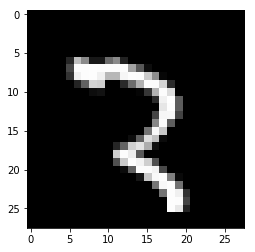

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = 500
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28), cmap='gray')
plt.show()

### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset`

In [4]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.shuffle(buffer_size = 10000)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


#### Define Iterator

In [5]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

## `tf.contrib.slim`

```python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# pylint: disable=unused-import,line-too-long,g-importing-member,wildcard-import
# TODO(jart): Delete non-slim imports
from tensorflow.contrib import losses
from tensorflow.contrib import metrics
from tensorflow.contrib.framework.python.ops.arg_scope import *
from tensorflow.contrib.framework.python.ops.variables import *
from tensorflow.contrib.layers.python.layers import *
from tensorflow.contrib.layers.python.layers.initializers import *
from tensorflow.contrib.layers.python.layers.regularizers import *
from tensorflow.contrib.slim.python.slim import evaluation
from tensorflow.contrib.slim.python.slim import learning
from tensorflow.contrib.slim.python.slim import model_analyzer
from tensorflow.contrib.slim.python.slim import queues
from tensorflow.contrib.slim.python.slim import summaries
from tensorflow.contrib.slim.python.slim.data import data_decoder
from tensorflow.contrib.slim.python.slim.data import data_provider
from tensorflow.contrib.slim.python.slim.data import dataset
from tensorflow.contrib.slim.python.slim.data import dataset_data_provider
from tensorflow.contrib.slim.python.slim.data import parallel_reader
from tensorflow.contrib.slim.python.slim.data import prefetch_queue
from tensorflow.contrib.slim.python.slim.data import tfexample_decoder
from tensorflow.python.util.all_util import make_all
# pylint: enable=unused-import,line-too-long,g-importing-member,wildcard-import

__all__ = make_all(__name__)
```

### Difference between [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) and [`tf.contrib.layers`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers)

#### [`tf.layers.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)
```python
tf.layers.conv2d(
    inputs,
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format='channels_last',
    dilation_rate=(1, 1),
    activation=None,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer(),
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    trainable=True,
    name=None,
    reuse=None
)
```

#### [`slim.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d)
```python
tf.contrib.layers.conv2d(
    inputs,
    num_outputs,
    kernel_size,
    stride=1,
    padding='SAME',
    data_format=None,
    rate=1,
    activation_fn=tf.nn.relu,
    normalizer_fn=None,
    normalizer_params=None,
    weights_initializer=initializers.xavier_initializer(),
    weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(),
    biases_regularizer=None,
    reuse=None,
    variables_collections=None,
    outputs_collections=None,
    trainable=True,
    scope=None
)
```

### Create the model

In [6]:
def cnn_model_fn(x):
  """Model function for CNN.
  Args:
    x: input images
    mode: boolean whether trainig mode or test mode
    
  Returns:
    logits: unnormalized score funtion
  """
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  # 여기를 직접 채워 넣으시면 됩니다.
  conv1 = slim.conv2d(x_image, 32, [5, 5])

  # Pooling Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool1 = slim.max_pool2d(conv1, [2, 2])
  
  # Convolutional Layer #2
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  conv2 = slim.conv2d(pool1, 64, [5, 5])

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool2 = slim.max_pool2d(conv2, [2, 2])

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool2_flat = slim.flatten(pool2)
  
  # Fully connected Layer
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  # 여기를 직접 채워 넣으시면 됩니다.
  fc1 = slim.fully_connected(pool2_flat, 1024, activation_fn=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  is_training = tf.placeholder(tf.bool)
  # 여기를 직접 채워 넣으시면 됩니다.
  fc1_drop = slim.dropout(fc1, 0.6, is_training=is_training)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  # 여기를 직접 채워 넣으시면 됩니다.
  logits = slim.fully_connected(fc1_drop, 10, activation_fn=tf.nn.relu)
  
  return logits, is_training, x_image

### Build the model

In [7]:
logits, is_training, x_image = cnn_model_fn(x)

### Define loss and optimizer

In [8]:
# 여기를 직접 채워 넣으시면 됩니다.
y_one_hot = tf.one_hot(y, 10)
cross_entropy = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=y_one_hot))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

### Assign `tf.summary.FileWriter`

In [9]:
graph_location = 'graphs/02_mnist_cnn_with_slim'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: graphs/02_mnist_cnn_with_slim


### `tf.summary`

In [10]:
with tf.name_scope('summaries'):
  tf.summary.scalar('loss/cross_entropy', cross_entropy)
  tf.summary.image('images', x_image)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  # merge all summaries
  summary_op = tf.summary.merge_all()

### `tf.Session()` and train

In [11]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_initializable_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
max_epochs = 2
step = 0
for epochs in range(max_epochs):
  # 여기를 직접 채워 넣으시면 됩니다.
  sess.run(train_iterator.initializer)

  start_time = time.time()
  while True:
    try:
      # 여기를 직접 채워 넣으시면 됩니다.
      _, loss = sess.run([train_step, cross_entropy], 
                         feed_dict={handle: train_handle, is_training:True})
      if step % 10 == 0:
        print("step: %d, loss: %g" % (step, loss))
        
        # summary
        summary_str = sess.run(summary_op,
                         feed_dict={handle: train_handle, is_training:True})
        train_writer.add_summary(summary_str, global_step=step)
        
      step += 1

    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      break
    
  print("Epochs: {} Elapsed time: {}".format(epochs, time.time() - start_time))

train_writer.close()
print("training done!")

step: 0, loss: 2.31413
step: 10, loss: 2.21872
step: 20, loss: 2.11076
step: 30, loss: 2.06672
step: 40, loss: 1.81771
step: 50, loss: 1.66868
step: 60, loss: 1.47269
step: 70, loss: 1.27892
step: 80, loss: 1.17966
step: 90, loss: 0.994523
step: 100, loss: 0.620166
step: 110, loss: 0.822477
step: 120, loss: 0.45813
step: 130, loss: 0.633566
step: 140, loss: 0.390372
step: 150, loss: 0.417386
step: 160, loss: 0.299729
step: 170, loss: 0.376684
step: 180, loss: 0.316323
step: 190, loss: 0.281795
step: 200, loss: 0.416732
step: 210, loss: 0.834931
step: 220, loss: 0.507515
step: 230, loss: 0.169468
step: 240, loss: 0.353798
step: 250, loss: 0.140062
step: 260, loss: 0.278425
step: 270, loss: 0.101519
step: 280, loss: 0.42218
step: 290, loss: 0.260041
step: 300, loss: 0.422316
step: 310, loss: 0.245676
step: 320, loss: 0.258643
step: 330, loss: 0.409888
step: 340, loss: 0.40515
step: 350, loss: 0.150999
step: 360, loss: 0.31755
step: 370, loss: 0.125788
step: 380, loss: 0.199848
step: 390,

step: 3020, loss: 0.0102455
step: 3030, loss: 0.0199806
step: 3040, loss: 0.0307569
step: 3050, loss: 0.0855085
step: 3060, loss: 0.122695
step: 3070, loss: 0.0364364
step: 3080, loss: 0.0115856
step: 3090, loss: 0.0185213
step: 3100, loss: 0.0179669
step: 3110, loss: 0.0207366
step: 3120, loss: 0.115116
step: 3130, loss: 0.0890324
step: 3140, loss: 0.0376131
step: 3150, loss: 0.0409208
step: 3160, loss: 0.123736
step: 3170, loss: 0.117231
step: 3180, loss: 0.00607836
step: 3190, loss: 0.0660428
step: 3200, loss: 0.488534
step: 3210, loss: 0.0812929
step: 3220, loss: 0.128541
step: 3230, loss: 0.0274213
step: 3240, loss: 0.100071
step: 3250, loss: 0.0171381
step: 3260, loss: 0.00829276
step: 3270, loss: 0.0277011
step: 3280, loss: 0.0400591
step: 3290, loss: 0.0238682
step: 3300, loss: 0.137709
step: 3310, loss: 0.0112257
step: 3320, loss: 0.0345276
step: 3330, loss: 0.0256569
step: 3340, loss: 0.0499375
step: 3350, loss: 0.104281
step: 3360, loss: 0.0536238
step: 3370, loss: 0.0024713

slim: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py

### Test trained model

In [12]:
# test_iterator
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())
sess.run(test_iterator.initializer)

In [13]:
accuracy, acc_op = tf.metrics.accuracy(labels=y, predictions=tf.argmax(logits, 1), name='accuracy')
sess.run(tf.local_variables_initializer())

sess.run(acc_op, feed_dict={handle: test_handle, is_training: False})
print("test accuracy:", sess.run(accuracy, feed_dict={handle: test_handle, is_training: False}))

test accuracy: 0.9837


### Print results

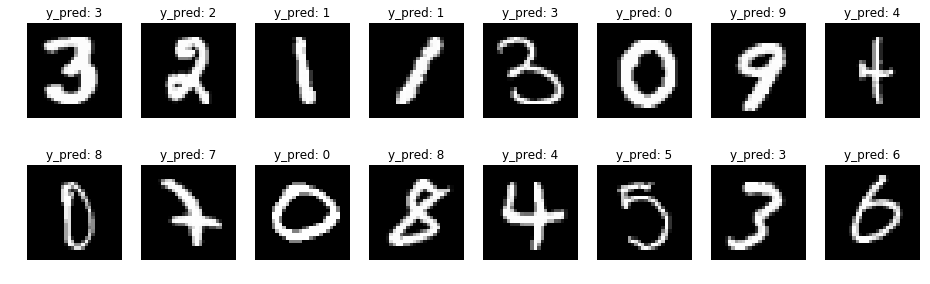

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)
batch_xs = test_data[batch_index]
y_pred = sess.run(logits, feed_dict={x: batch_xs, is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
  p = fig.add_subplot(4, 8, i+1)
  p.set_title("y_pred: {}".format(np.argmax(py)))
  p.imshow(px.reshape(28, 28), cmap='gray')
  p.axis('off')

## 직접 실습

* 여러가지 hyper-parameter들을 바꿔가면서 accuracy를 높혀보자